In [23]:
from LSTM_enc_dec2 import *
import xarray as xr
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

#plt.style.use("../plotting.mplstyle")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<xarray.DataArray (eof: 30, time: 132001)>
[3960030 values with dtype=float64]
Coordinates:
  * eof      (eof) int32 0 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27 28 29
  * time     (time) object 0001-12-31 12:00:00 ... 11001-12-31 12:00:00 <class 'xarray.core.dataarray.DataArray'>
92400 26400
(30, 92400) (30, 26400) (30, 13201)
[-1.0817188  -1.29517722 -1.55209658 ... -1.25901466 -1.26322655
 -1.28801876] (92400,)


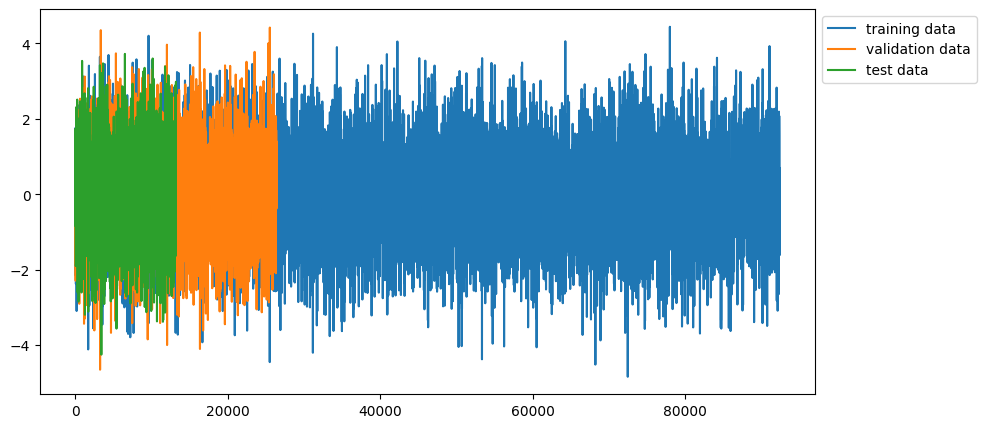

In [24]:
data = xr.open_dataarray("./synthetic_data/lim_integration_xarray_130k[-1]q.nc")

print(data, type(data))

idx_train = int(len(data['time']) * 0.7)
idx_val = int(len(data['time']) * 0.2)
print(idx_train, idx_val)

train_data = data[: :,  :idx_train]
val_data = data[: :, idx_train: idx_train+idx_val]
test_data = data[: :, idx_train+idx_val: ]

train_datan = train_data.data
val_datan = val_data.data
test_datan = test_data.data

In [25]:
# Convert to torch.Dataset
input_window = 6
output_window = 12
batch_size = 32
one_hot_month = False

train_dataset = TimeSeriesLSTM(train_data, input_window, output_window, one_hot_month=one_hot_month)
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TimeSeriesLSTM(val_data, input_window, output_window)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True)

print("Train dataset: ", train_dataset)

Train dataset:  <LSTM_enc_dec2.TimeSeriesLSTM object at 0x000002438DF8A740>


torch.Size([30, 6]) torch.Size([30, 12])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


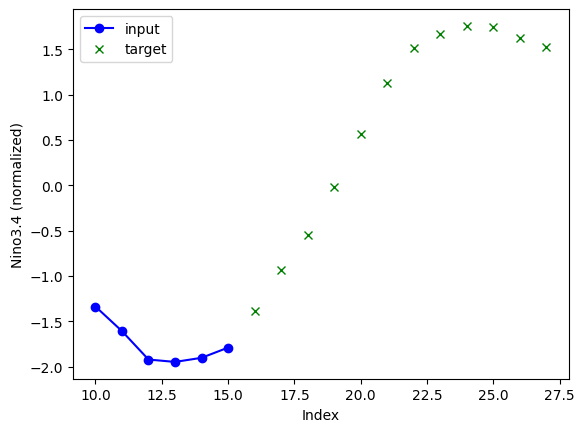

In [27]:
# Sample datapoint
input, target, l = train_dataset[10]

pc_num = 0

fig, ax = plt.subplots()
ax.plot(l['idx_input'], input[pc_num, :], 'bo-', label='input')
ax.plot(l['idx_target'], target[pc_num , :], 'gx', label='target')
ax.set_xlabel("Index")
ax.set_ylabel(f"PC {pc_num} ")
_ = ax.legend()

In [ ]:
# Setting hyperparameters for training
num_features = 30
hidden_size = 64
num_layers = 2
learning_rate = 0.001
num_epochs = 100
input_window = input_window
output_window = output_window
batch_size = 64
training_prediction = "recursive"
teacher_forcing_ratio = 0.5
dynamic_tf = True
shuffle = True
loss_type = "L1"
wind_farm = "britain_time_lag_corr_"

print("Start training")

# Specify the device to be used for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTM_Sequence_Prediction(input_size = num_features, hidden_size = hidden_size, num_layers=num_layers)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss, loss_test = model.train_model(train_dataloader,
                                    val_dataloader,                       num_epochs,
                                    input_window,
                                    output_window,
                                    batch_size,
                                    training_prediction,
                                    teacher_forcing_ratio,
                                    learning_rate,
                                    dynamic_tf,
                                    loss_type,
                                    optimizer, num_features)


rand_identifier = np.random.randint(0, 10000000)
print(f"Model saved as model_{rand_identifier}.pt")

# Save the model and hyperparameters to a file
parameters = {
    'hidden_size': hidden_size,
    "num_layers": num_layers,
    'learning_rate': learning_rate,
    'num_epochs': num_epochs,
    "input_window": input_window,
    "output_window": output_window,
    "batch_size": batch_size,
    "training_prediction": training_prediction,
    "teacher_forcing_ratio": teacher_forcing_ratio,
    "dynamic_tf": dynamic_tf,
    "loss": loss.tolist(),
    "loss_test": loss_test.tolist(),
    "loss_type": loss_type,
    "shuffle": shuffle,
    "wind_farm": wind_farm,
}

torch.save({'hyperparameters': parameters,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()},
           f'./trained_models/model_{rand_identifier}.pt')